In [122]:
import yfinance as yf
import matplotlib.pyplot as plt
import indicators
from indicators import *
import params
from params import *
import os
import importlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import seaborn as sns

importlib.reload(params)
importlib.reload(indicators)

<module 'indicators' from '/Users/romaindesmeulemester/ProjetMachineLearning/ProjetMachineLearning/indicators.py'>

On créer la fonction d'extraction des données

In [114]:
def extract_data(ticker, name, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    data = data.dropna()
    data = data[data["Volume"] > 0]
    data["VariationN"] = (data["Close"].shift(-1) / data["Close"] - 1) * 100
    data["VariationN-1"] = data["VariationN"].shift(1)
    data["Trend"] = (data["VariationN"] > 0).astype(int)

    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data["Date"] = data.index
    data = data.dropna()
    data.columns.name = None
    data.insert(0, 'Indice', name)

    return data

La fonction qui rajoute les indicateurs

In [115]:
def add_indicators(data, params_ma, params_ema, params_rsi, params_macd, params_std, params_bollinger):
    data = data.copy()

    for x in params_ma:
        col_name = "MA_" + str(x)
        data.loc[:, col_name] = MA(data["Close"], x)

    for x in params_ema:
        col_name = "EMA_" + str(x)
        data.loc[:, col_name] = EMA(data["Close"], x)

    for x in params_rsi:
        col_name = "RSI_" + str(x)
        data.loc[:, col_name] = RSI(data["Close"], x)

    for x in params_std:
        col_name = "STD_" + str(x)
        data.loc[:, col_name] = STD(data["Close"], x)

    data.loc[:, "MACD"], data.loc[:, "Signal"] = MACD(data["Close"], params_macd[0], params_macd[1], params_macd[2])
    data.loc[:, "BollingerBandUpper"], data.loc[:, "BollingerBandLower"] = BollingerBands(data["Close"], params_bollinger[0], params_bollinger[1])

    return data

Création de la base_clean et de la base_indice

In [ ]:
def create_base_clean(indices, start_date, end_date):
    data = pd.DataFrame()
    base_list = []
    for index in indices:
        base_list = data.append(extract_data(index[0], index[1], start_date, end_date))
        data = data.dropna()
    base_clean = pd.concat(base_list)
    base_clean = base_clean.reset_index(drop=True)
    
    return data

In [ ]:
def base_normalise(data):
    

In [117]:
if isimport:
    base_clean = create_base_clean(indices, start_date, end_date)
    file_path = base_dir + "/base_clean.csv"

    
    base_clean.to_csv(file_path)

else:
    file_path = base_dir + "/base_clean.csv"
    base_clean = pd.read_csv(file_path)

indice_list = base_clean["Indice"].unique()

base_list = []

for indice in indice_list:
    data = base_clean[base_clean["Indice"] == indice]
    data = add_indicators(data, params_ma, params_ema, params_rsi, params_macd, params_std, params_bollinger)
    base_list.append(data)

base_indice = pd.concat(base_list)
base_indice = base_indice.dropna()
base_indice = base_indice.reset_index(drop=True)

file_path = base_dir + "/base_indice.csv"
base_indice.to_csv(file_path)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [123]:
base_corr = base_indice.drop(["Date", "Indice"], axis=1)
correlation_matrix = base_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")

file_path = plot_dir + "/correlation_heatmap.png"
plt.savefig(file_path, bbox_inches="tight", dpi=300)

plt.close()
print(f"✅ Heatmap enregistrée dans {file_path}")

✅ Heatmap enregistrée dans /Users/romaindesmeulemester/ProjetMachineLearning/ProjetMachineLearning/plots/correlation_heatmap.png


Préparation pour entrainement

In [93]:
X = base_indice.drop(columns=["VariationN", "Indice", "Date"])
Y = base_indice["VariationN"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)

Régression linéaire

In [94]:
model = LinearRegression()
model.fit(X_train, Y_train)

# Affichage des coefficients
coefficients_linéaire = pd.DataFrame(np.append(model.intercept_, model.coef_),
                                    index=["Intercept"] + list(X_train.columns),
                                    columns=["Coefficients (Sklearn)"])
print(coefficients_linéaire)

# Prédictions avec Scikit-Learn
Y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² : {r2:.4f}")

                    Coefficients (Sklearn)
Intercept                    -8.953389e-01
Close                        -3.270751e-04
High                          7.043108e-04
Low                           8.041076e-05
Open                         -2.971342e-04
Volume                       -9.159111e-13
VariationN-1                 -2.456570e-02
Trend                         1.737194e+00
MA_5                         -1.576370e-04
MA_15                         5.664791e-05
EMA_5                        -1.215497e-03
EMA_15                        1.196498e-03
RSI_14                        6.779891e-05
STD_10                        1.194434e-04
STD_20                       -3.221264e-06
MACD                          2.721134e-03
Signal                       -1.976747e-03
BollingerBandUpper           -2.907852e-05
BollingerBandLower           -1.619346e-05
MSE : 0.8835
MAE : 0.6354
R² : 0.4545


/Users/romaindesmeulemester/ProjetMachineLearning/ProjetMachineLearning/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


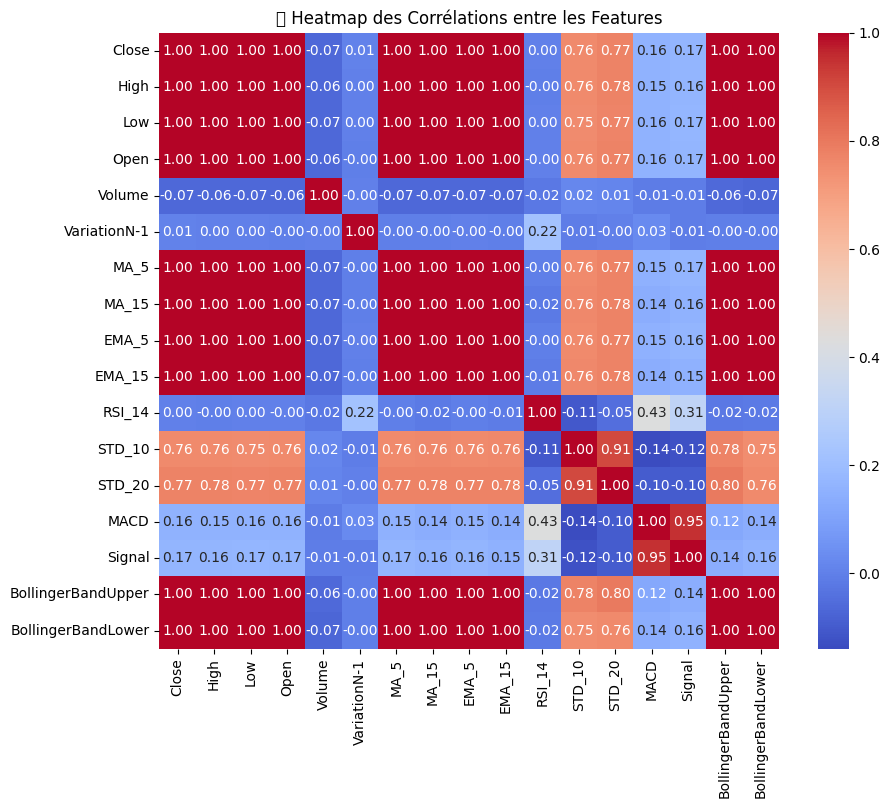

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Calcul de la matrice de corrélation
correlation_matrix = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔍 Heatmap des Corrélations entre les Features")
plt.show()

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)

X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

# 🔹 2. Initialisation des poids (paramètres)
n_features = X_train_b.shape[1]  # Nombre de variables + biais
theta = np.random.randn(n_features, 1) * 0.01  # Petites valeurs pour éviter la divergence

# Conversion de Y_train en matrice NumPy
Y_train_np = Y_train.values.reshape(-1, 1)

# 🔹 3. Descente de gradient
alpha = 0.01  # Taux d'apprentissage
n_iterations = 5000  # Nombre d'itérations
m = X_train_b.shape[0]  # Nombre d'exemples
losses = []  # Liste pour stocker l'évolution de la perte

for iteration in range(n_iterations):
    # Calcul des prédictions
    Y_pred_train = X_train_b @ theta  
    
    # Calcul des erreurs
    errors = Y_pred_train - Y_train_np  
    
    # Calcul des gradients
    gradients = (2/m) * X_train_b.T @ errors  
    
    # Mise à jour des poids
    theta -= alpha * gradients  
    
    # Calcul de la perte (MSE)
    mse = np.mean(errors**2)
    losses.append(mse)
    
    # Arrêt précoce si la perte devient stable
    if iteration > 1 and abs(losses[-1] - losses[-2]) < 1e-10:
        print(f"✅ Convergence atteinte à l'itération {iteration}")
        break

# 🔹 4. Prédiction avec le modèle entraîné
Y_pred_GD = X_test_b @ theta  

# 🔹 5. Évaluation du modèle
mse_GD = mean_squared_error(Y_test, Y_pred_GD)
mae_GD = mean_absolute_error(Y_test, Y_pred_GD)
r2_GD = r2_score(Y_test, Y_pred_GD)

print(f"\n📊 Performance du modèle (Descente de Gradient) :")
print(f"MSE : {mse_GD:.4f}")
print(f"MAE : {mae_GD:.4f}")
print(f"R² : {r2_GD:.4f}")

# 🔹 Affichage des coefficients trouvés
coefficients_GD = pd.DataFrame(theta, index=["Intercept"] + list(X_train.columns), columns=["Coefficients (GD)"])
display(coefficients_GD)

resultats_GD = pd.DataFrame({"Valeur réelle": Y_test.values, "Prédiction GD": Y_pred_GD.flatten()})
display(resultats_GD.head(10))

NameError: name 'BaseTotal' is not defined